# HPGE Gamma Spectroscopy - Spectral Analysis

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit


In [13]:
#store reference photopeaks as pd.DataFrame
pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals

def peak_df(filename):
    ''' This function converts the peak data csv into  a pandas dataframe 
       Input: filename - file path of csv
       Output: df2 '''
    df = pd.read_csv(filename,delimiter = ',',header = [0,1]).droplevel(1,axis = 1)
    rename_dict = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'
    ,' FWHM':'FWHM','  Net_Area':'Net_Area_Count'}
    #dtype_dict = {'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float,'FWHM':float,'Net_Area_Count':float,''}
    df.rename(columns = rename_dict,inplace = True)
    df2 = df.merge(pp_df,how = 'left' ,on = ['Nuclide','Photopeak_Energy'])  #match BR to peak
    df2['Centroid_err'] = df2['FWHM']/2/np.sqrt(2*np.log(2)*df2['Net_Area_Count'])#Centroid error
    df2['FWHM_err'] = df2['Centroid_err']*np.sqrt(np.log(2))*2 #FWHM error 
    df2['Resolution'] = df2['FWHM']/df2['Centroid']
    df2['Resolution_err']= df2['Resolution']*np.sqrt((df2['Centroid_err']/df2['Centroid'])**2+(df2['FWHM_err']/df2['FWHM'])**2)
    return df2
    
class peak():
    def __init__(self,df):
        self.df = df
    def name(self,name):
        return self.df.loc[self.df.isin({'Nuclide':[name]})]
        


/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_3048/3354312982.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


In [14]:
path1 = 'peaks/peaks_sample1_30_10_23_Mon_09_22.CSV' #peak sample 1
path_bg = 'peaks/peaks_background_17_10_23.csv'
df_1 = peak_df(path1)
df_bg= peak_df(path_bg)

In [15]:
def chi2_prob(fit,data,err,df):
    '''This function calculates chi2 probability for given 
       fit array, data array,err and degrees of freedom 
       Inputs: fit  - array of fitted values
               data - array of original data
               err  - error 
               df   - degree of freedom
       Outputs: chi2 probability, 
       the probability of obtaining a value of minimized chi2 
       equal to the fit value or higher, given df'''
    norm_resid = (fit -data)/err #normalized residual
    chi2 = np.sum(norm_resid**2) #chi-square
    chi2_red = chi2/df
    chi2_p = 1-stats.chi2.cdf(chi2,df) #chi2 probability =  1-cumulative distribution function
    print(f' chi2: {chi2} \n reduced chi2: {chi2_red}\n chi2 p-value: {chi2_p}')
    return chi2,chi2_red, chi2_p

FWHM of Gaussian = $2\sqrt{2\ln{2}}\sigma$, where $\sigma$ is standard deviation. \
Error in centroid of Gaussian can be given by standard error on mean, which is $\sigma/\sqrt{n}$. \
$n$ is the number of samples, i.e. total no. of counts under the peak in this  case

Loading peak data csv into pd.DataFrame

## Energy Calibration

In [16]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = grad * channel# + interc
grad = 0.6775230169 #gradient
interc = -0.3439140022 #intercept
energy_to_chan = np.poly1d([1/grad,-interc/grad])


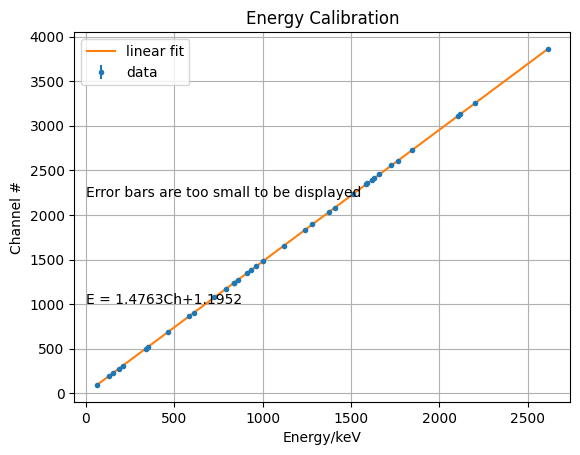

In [17]:
df_new = df_1.dropna(subset = ['Photopeak_Energy']) #drop unidentified peaks
df_new = df_new[df_new['Reduced']<2] #omit peaks with poor fit (reduced chi2 >2 )
x = df_new['Photopeak_Energy']
y = energy_to_chan(df_new['Centroid'])
popt_peak, pcov_peak = np.polyfit(x,y,1,cov = True) #energy callibration using peak
perr_peak = np.sqrt(np.diag(pcov_peak))
peak_fit = np.poly1d(popt_peak)
y_err = 1/grad*df_new['Centroid_err']
#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,yerr= y_err, fmt = '.',label = 'data')
plt.plot(x,peak_fit(x),label = 'linear fit')
plt.legend()
plt.ylabel('Channel #')
plt.xlabel('Energy/keV')
plt.text(1,1000,f'E = {popt_peak[0]:.4f}Ch+{popt_peak[1]:.4f}')
plt.text(1,2200,'Error bars are too small to be displayed')
plt.grid()

In [18]:
print(f'Linear fit (energy to channel) using peak energy: E = {popt_peak[0]:.6f}Ch {popt_peak[1]:.6f}')
print(f'Original linear fit (energy to channel) : E = {1/grad:.6f}Ch {-interc/grad:.6f}' )
print('Errors on new fit:')
print(perr_peak)
chi2_prob(peak_fit(x),y,y_err,len(x)-2)

Linear fit (energy to channel) using peak energy: E = 1.476291Ch 1.195180
Original linear fit (energy to channel) : E = 1.475965Ch 0.507605
Errors on new fit:
[6.75176904e-05 8.74313426e-02]
 chi2: 2781.832628648044 
 reduced chi2: 79.48093224708698
 chi2 p-value: 0.0


(2781.832628648044, 79.48093224708698, 0.0)

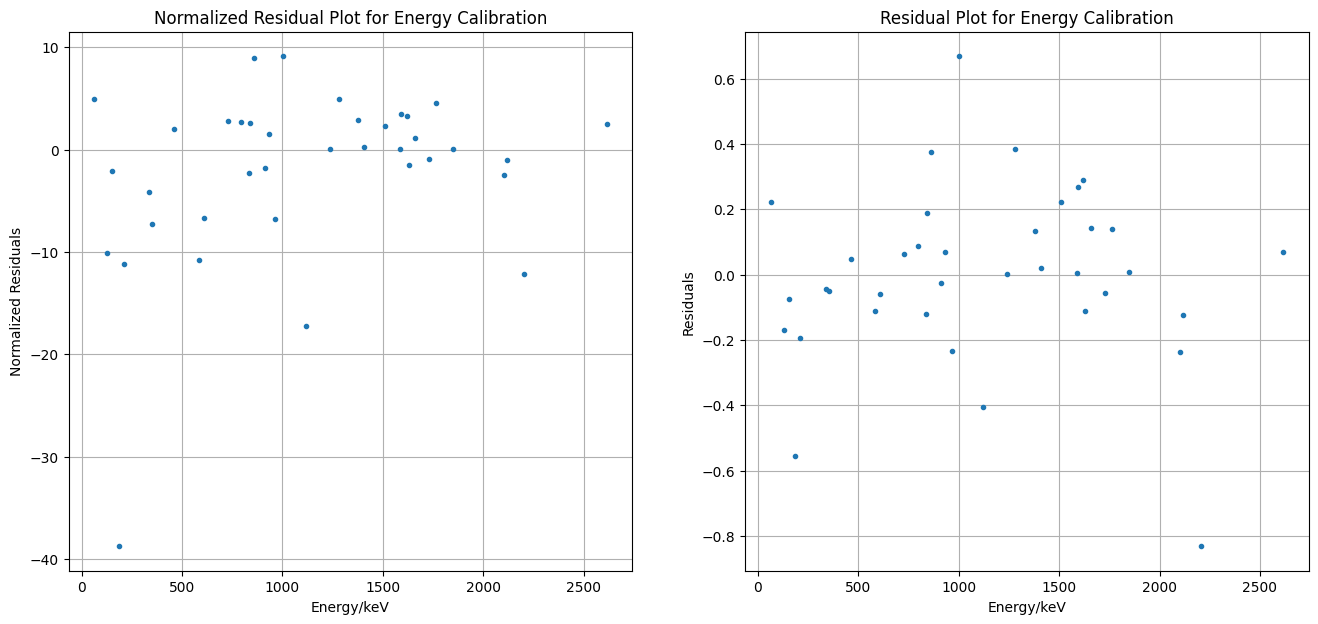

In [20]:
fig,ax = plt.subplots(1,2,figsize = (16,7))
ax[0].set_title('Normalized Residual Plot for Energy Calibration')
ax[0].plot(x,(y-peak_fit(x))/y_err,'.')
ax[0].set_xlabel('Energy/keV')
ax[0].set_ylabel('Normalized Residuals')
ax[0].grid()
ax[1].set_title('Residual Plot for Energy Calibration')
ax[1].plot(x,(y-peak_fit(x)),'.')
ax[1].set_xlabel('Energy/keV')
ax[1].set_ylabel('Residuals')
ax[1].grid()

In [19]:
chi2_prob(y,peak_fit(x),y_err,len(x)-2)

 chi2: 2781.832628648044 
 reduced chi2: 79.48093224708698
 chi2 p-value: 0.0


(2781.832628648044, 79.48093224708698, 0.0)

## Resolution Calibration

Resolution = $\frac{FWHM}{E_0}$,
where $FWHM = \sqrt{a \times E_0+b}$, a

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


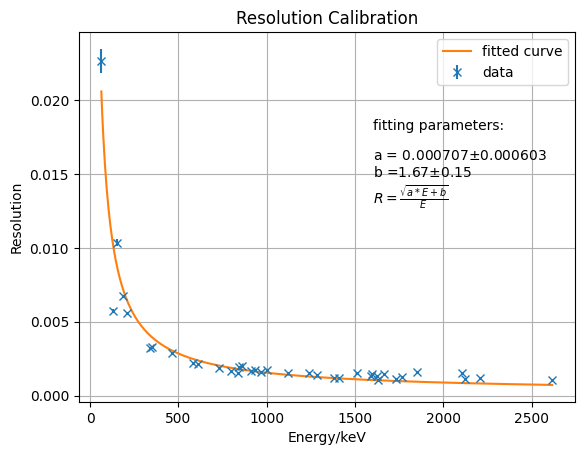

In [24]:
def res_fit(peak_energy,a,b):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - fitted centroid of labelled peaks
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy+b)/peak_energy
x_res = df_new['Centroid']
y_res = df_new['Resolution']
y_err_res = df_new['Resolution_err']
res_par, res_cov = curve_fit(res_fit,x_res,y_res)
res_fit_err = np.sqrt(np.diag(res_cov))
x_plot = np.linspace(min(x_res),max(x_res),500)

plt.figure()
plt.title('Resolution Calibration')
plt.errorbar(x_res,y_res,yerr = y_err_res,fmt = 'x',label = 'data')
plt.plot(x_plot,res_fit(x_plot,*res_par), label = 'fitted curve')
plt.ylabel('Resolution')
plt.xlabel('Energy/keV')
plt.legend()
plt.text(1600,0.018,f'fitting parameters:')
plt.text(1600,0.016,f'a = {res_par[0]:.3g}' + r'$\pm$'+ f'{res_fit_err[0]:.3g}')
plt.text(1600,0.0148,f'b ={res_par[1]:.3g}' + r'$\pm$'+ f'{res_fit_err[1]:.3g}')
plt.text(1600,0.013,r'$R = \frac{\sqrt{a * E+b}}{E}$')
plt.grid()

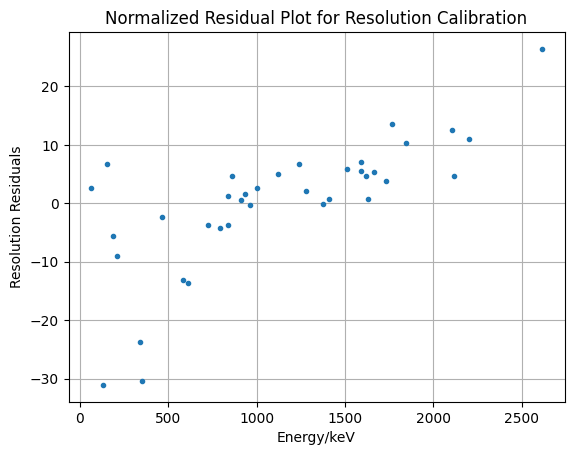

In [26]:
plt.figure()
plt.title('Normalized Residual Plot for Resolution Calibration')
plt.plot(x_res,(y_res-res_fit(x_res,*res_par))/y_err_res,'.')
plt.xlabel('Energy/keV')
plt.ylabel('Resolution Residuals')
plt.grid()

In [28]:
chi2_prob(y_res,res_fit(x_res,*res_par),y_err_res,len(x_res)-2)

 chi2: 4607.774109020733 
 reduced chi2: 131.65068882916378
 chi2 p-value: 0.0


(4607.774109020733, 131.65068882916378, 0.0)

In [ ]:
res_fit(centroid_1,2,3)

array([0.17956965, 0.16431108, 0.16222303, 0.14760751, 0.12502091,
       0.11435316, 0.10401667, 0.09802493, 0.09176062, 0.09118661,
       0.08179327, 0.07699868, 0.0754909 , 0.06578771, 0.05861027,
       0.05733632, 0.0550143 , 0.05246821, 0.05104423, 0.05047696,
       0.05018373, 0.04894725, 0.0488048 , 0.04822505, 0.04687165,
       0.04629227, 0.04555366, 0.04545355, 0.04470723, 0.04227221,
       0.04020392, 0.03952119, 0.03811036, 0.03769867, 0.03700847,
       0.03640963, 0.03549402, 0.0354436 , 0.03513619, 0.03502975,
       0.03470307, 0.03401182, 0.03367231, 0.03290826, 0.03084011,
       0.03072997, 0.03012991, 0.02858782, 0.02766   ])

In [ ]:
pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals
# pp_df[pp_df['Nuclide'] == 'Pb214']

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_56047/3455819057.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


In [ ]:
peak_1.rename(columns = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'},inplace = True)
peak_1[1:] = peak_1[1:].astype({'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float}, errors = 'ignore')
df_1 = peak_1[1:].merge(pp_df,on = ['Nuclide','Photopeak_Energy'])  #match BR to peak
Bi214 = df_1[df_1['Nuclide']=='Bi214'][['Photopeak_Energy','Peak_CPS','BR']].to_numpy(dtype = float).transpose()
Ac228 = df_1[df_1['Nuclide']=='Ac228'][['Photopeak_Energy','Peak_CPS','BR']].to_numpy(dtype = float).transpose()
Bi214_activity = Bi214[1]/Bi214[2]
Ac228_activity = Ac228[1]/Ac228[2]

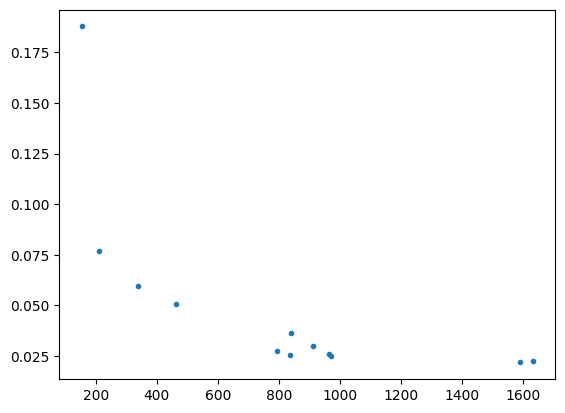

In [ ]:
#plt.plot(Bi214[0],Bi214_activity,'.')
plt.plot(Ac228[0],Ac228_activity,'.')


In [ ]:
plt.plot(Bi214[0],activity,'.')

In [ ]:
peak_1[1:].dtypes

Centroid             object
  Net_Area           object
   Net_Area          object
Peak_CPS             object
 FWHM                object
   FWHM              object
Reduced              object
 ROI_Total           object
ROI                  object
 File                object
                     object
                     object
     .1              object
Nuclide              object
Photopeak_Energy     object
 ROI_Lower_Energy    object
 ROI_Upper_Energy    object
 Color               object
 User_Label          object
 Continuum_Type      object
dtype: object

,Centroid,Net_Area,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,,,.1,Nuclide,Photopeak_Energy,ROI_Lower_Energy,ROI_Upper_Energy,Color,User_Label,Continuum_Type
1,63.49,402.7,98.5,0.000683,1.44,2.27%,1.32,43289.7,1,,589248.000,NaN,NaN,Th234,62.86,54.536,68.0868,#9933FF,NaN,Linear
2,75.55,3838.8,119.4,0.006515,1.49,1.97%,56.12,127454.9,2,,589248.000,NaN,NaN,Pb212 (x-ray),74.82,60.6338,92.4783,#830808,NaN,Linear
3,77.47,4338.5,124.9,0.007363,1.47,1.90%,56.12,127454.9,3,,589248.000,NaN,NaN,Pb212 (x-ray),77.11,60.6338,92.4783,#830808,NaN,Linear
4,93.27,1961.6,124.8,0.003329,1.16,1.24%,20.51,42853.6,4,,589248.000,NaN,NaN,Th234,92.8,88.4131,99.2538,#9933FF,NaN,Linear
5,129.44,771.6,82.1,0.001309,0.74,0.57%,1.22,41468.9,5,,589248.000,NaN,NaN,Ac228,129.06,124.001,133.809,#cc3333,NaN,Linear
6,154.43,798.6,177.6,0.001355,1.60,1.03%,1.51,17018.6,6,,589248.000,NaN,NaN,Ac228,153.98,152.781,156.846,#cc3333,NaN,Linear
7,186.34,2976.8,139.3,0.005052,1.25,0.67%,1.77,46103.3,7,,589248.000,NaN,NaN,Ra226,186.21,179.883,191.402,NaN,NaN,Linear
8,209.63,1764.3,130.3,0.002994,1.17,0.56%,1.33,36381.8,8,,589248.000,NaN,NaN,Ac228,209.25,205.631,215.794,#cc3333,NaN,Linear
9,239.02,19111.0,168.5,0.032433,0.98,0.41%,6.56,83389.6,9,,589248.000,NaN,NaN,Pb212,238.63,229.346,248.996,#830808,NaN,Linear
10,242.02,4674.7,140.8,0.007933,1.69,0.70%,6.56,83389.6,10,,589248.000,NaN,NaN,Pb214,242.0,229.346,248.996,NaN,NaN,Linear


In [ ]:
peak_1

,Centroid,Net_Area,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,,,.1,Nuclide,Photopeak_Energy,ROI_Lower_Energy,ROI_Upper_Energy,Color,User_Label,Continuum_Type
0,keV,Counts,Uncertainty,CPS,keV,Percent,Chi_Sqr,Counts,ID#,Name,LiveTime,Date,Time,,keV,keV,keV,(css),,
1,63.49,402.7,98.5,0.000683,1.44,2.27%,1.32,43289.7,1,,589248.000,NaN,NaN,Th234,62.86,54.536,68.0868,#9933FF,NaN,Linear
2,75.55,3838.8,119.4,0.006515,1.49,1.97%,56.12,127454.9,2,,589248.000,NaN,NaN,Pb212 (x-ray),74.82,60.6338,92.4783,#830808,NaN,Linear
3,77.47,4338.5,124.9,0.007363,1.47,1.90%,56.12,127454.9,3,,589248.000,NaN,NaN,Pb212 (x-ray),77.11,60.6338,92.4783,#830808,NaN,Linear
4,93.27,1961.6,124.8,0.003329,1.16,1.24%,20.51,42853.6,4,,589248.000,NaN,NaN,Th234,92.8,88.4131,99.2538,#9933FF,NaN,Linear
5,129.44,771.6,82.1,0.001309,0.74,0.57%,1.22,41468.9,5,,589248.000,NaN,NaN,Ac228,129.06,124.001,133.809,#cc3333,NaN,Linear
6,154.43,798.6,177.6,0.001355,1.60,1.03%,1.51,17018.6,6,,589248.000,NaN,NaN,Ac228,153.98,152.781,156.846,#cc3333,NaN,Linear
7,186.34,2976.8,139.3,0.005052,1.25,0.67%,1.77,46103.3,7,,589248.000,NaN,NaN,Ra226,186.21,179.883,191.402,NaN,NaN,Linear
8,209.63,1764.3,130.3,0.002994,1.17,0.56%,1.33,36381.8,8,,589248.000,NaN,NaN,Ac228,209.25,205.631,215.794,#cc3333,NaN,Linear
9,239.02,19111.0,168.5,0.032433,0.98,0.41%,6.56,83389.6,9,,589248.000,NaN,NaN,Pb212,238.63,229.346,248.996,#830808,NaN,Linear
